In [1]:
from math import log
import operator
import treePlotter
import matplotlib.pyplot as plt
%matplotlib inline

### createDataSet

In [2]:
def createDataSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    dataSet = [[0, 0, 0, 0, 'N'], 
               [0, 0, 0, 1, 'N'], 
               [1, 0, 0, 0, 'Y'], 
               [2, 1, 0, 0, 'Y'], 
               [2, 2, 1, 0, 'Y'], 
               [2, 2, 1, 1, 'N'], 
               [1, 2, 1, 1, 'Y']]
    labels = ['outlook', 'temperature', 'humidity', 'windy']
    return dataSet, labels

--------------

In [54]:
dataSet, labels = createDataSet()
print dataSet
print labels

[[0, 0, 0, 0, 'N'], [0, 0, 0, 1, 'N'], [1, 0, 0, 0, 'Y'], [2, 1, 0, 0, 'Y'], [2, 2, 1, 0, 'Y'], [2, 2, 1, 1, 'N'], [1, 2, 1, 1, 'Y']]
['outlook', 'temperature', 'humidity', 'windy']


In [15]:
labels_tmp = labels[:]
print labels_tmp

['outlook', 'temperature', 'humidity', 'windy']


--------------

### createTree

In [22]:
def majorityCnt(classList):
    """
    输入：分类类别列表
    输出：子节点的分类
    描述：数据集已经处理了所有属性，但是类标签依然不是唯一的，
          采用多数判决的方法决定该子节点的分类
    """
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reversed=True)
    return sortedClassCount[0][0]

In [41]:
def calcShannonEnt(dataSet):
    """
    输入：数据集
    输出：数据集的香农熵
    描述：计算给定数据集的香农熵；熵越大，数据集的混乱程度越大
    """
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1      # 数每一类各多少个， {'Y': 4, 'N': 3}
    shannonEnt = 0.0
    for key in labelCounts:
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * log(prob, 2)
    return shannonEnt

--------------

In [31]:
numEntries = len(dataSet)
labelCounts = {}

7

--------------

In [45]:
def chooseBestFeatureToSplit(dataSet):
    """
    输入：数据集
    输出：最好的划分维度
    描述：选择最好的数据集划分维度
    """
    numFeatures = len(dataSet[0]) - 1                 #feature个数
    baseEntropy = calcShannonEnt(dataSet)             #整个dataset的熵
    bestInfoGainRatio = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]  #每个feature的list
        uniqueVals = set(featList)                      #每个list的唯一值集合                 
        newEntropy = 0.0
        splitInfo = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)  #每个唯一值对应的剩余feature的组成子集
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
            splitInfo += -prob * log(prob, 2)
        infoGain = baseEntropy - newEntropy              #这个feature的infoGain
        if (splitInfo == 0): # fix the overflow bug
            continue
        infoGainRatio = infoGain / splitInfo             #这个feature的infoGainRatio      
        if (infoGainRatio > bestInfoGainRatio):          #选择最大的gain ratio
            bestInfoGainRatio = infoGainRatio
            bestFeature = i                              #选择最大的gain ratio对应的feature
    return bestFeature

--------------

In [30]:
baseEntropy = calcShannonEnt(dataSet)
baseEntropy

0.9852281360342516

--------------

In [8]:
def splitDataSet(dataSet, axis, value):
    """
    输入：数据集，选择维度，选择值
    输出：划分数据集
    描述：按照给定特征划分数据集；去除选择维度中等于选择值的项
    """
    retDataSet = []
    for featVec in dataSet:
        print featVec
        print featVec[axis]
        if featVec[axis] == value:                      #只看当第i列的值＝value时的item
            reduceFeatVec = featVec[:axis]              #featVec的第i列给除去
            reduceFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reduceFeatVec)            
    return retDataSet


--------------

In [47]:
value = set([0,1,2,2])
print value
value = 0

set([0, 1, 2])


In [48]:
splitDataSet(dataSet, 0, value)

[[0, 0, 0, 'N'], [0, 0, 1, 'N']]

--------------

In [58]:
def createTree(dataSet, labels):
    """
    输入：数据集，特征标签
    输出：决策树
    描述：递归构建决策树，利用上述的函数
    """
    classList = [example[-1] for example in dataSet]         # ['N', 'N', 'Y', 'Y', 'Y', 'N', 'Y']
    if classList.count(classList[0]) == len(classList):
        # classList所有元素都相等，即类别完全相同，停止划分
        return classList[0]                                  #splitDataSet(dataSet, 0, 0)此时全是N，返回N
    if len(dataSet[0]) == 1:                                 #[0, 0, 0, 0, 'N'] 
        # 遍历完所有特征时返回出现次数最多的
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)             #0－> 2       
    bestFeatLabel = labels[bestFeat]                         #outlook -> windy     
    myTree = {bestFeatLabel:{}}                   
        #多重字典构建树{'outlook': {0: 'N'
    del(labels[bestFeat])                                    #['temperature', 'humidity', 'windy'] -> ['temperature', 'humidity']        
    featValues = [example[bestFeat] for example in dataSet]  #[0, 0, 1, 2, 2, 2, 1]     
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]                                #['temperature', 'humidity', 'windy']    
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    return myTree

--------------

In [62]:
createTree(splitDataSet(dataSet, 0, 0), ['temperature', 'humidity', 'windy'])

'N'

In [61]:
dataSet, labels = createDataSet()
labels_tmp = labels[:]

In [60]:
createTree(dataSet, labels_tmp)

0
outlook
['temperature', 'humidity', 'windy']
[0, 0, 1, 2, 2, 2, 1]
0
['temperature', 'humidity', 'windy']
N
1
['temperature', 'humidity', 'windy']
Y
2
['temperature', 'humidity', 'windy']
2
windy
['temperature', 'humidity']
[0, 0, 1]
0
['temperature', 'humidity']
Y
1
['temperature', 'humidity']
N
{'windy': {0: 'Y', 1: 'N'}}


{'outlook': {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}

--------------

In [65]:
desicionTree = createTree(dataSet, labels_tmp)
print desicionTree

0
outlook
['temperature', 'humidity', 'windy']
[0, 0, 1, 2, 2, 2, 1]
0
['temperature', 'humidity', 'windy']
N
1
['temperature', 'humidity', 'windy']
Y
2
['temperature', 'humidity', 'windy']
2
windy
['temperature', 'humidity']
[0, 0, 1]
0
['temperature', 'humidity']
Y
1
['temperature', 'humidity']
N
{'windy': {0: 'Y', 1: 'N'}}
{'outlook': {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}


/Users/galphen/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:3145: RuntimeWarning: invalid value encountered in double_scalars
  ddx = pad_projected * dx / cp_distance
/Users/galphen/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:3146: RuntimeWarning: invalid value encountered in double_scalars
  ddy = pad_projected * dy / cp_distance
/Users/galphen/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:3149: RuntimeWarning: invalid value encountered in double_scalars
  dx = dx / cp_distance * head_dist
/Users/galphen/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:3150: RuntimeWarning: invalid value encountered in double_scalars
  dy = dy / cp_distance * head_dist


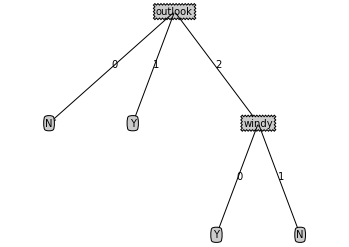

In [17]:
treePlotter.createPlot(desicionTree)

### createTestSet

In [18]:
def createTestSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true 
    """
    testSet = [[0, 1, 0, 0], 
               [0, 2, 1, 0], 
               [2, 1, 1, 0], 
               [0, 1, 1, 1], 
               [1, 1, 0, 1], 
               [1, 0, 1, 0], 
               [2, 1, 0, 1]]
    return testSet

In [19]:
testSet = createTestSet()
print testSet

[[0, 1, 0, 0], [0, 2, 1, 0], [2, 1, 1, 0], [0, 1, 1, 1], [1, 1, 0, 1], [1, 0, 1, 0], [2, 1, 0, 1]]


In [68]:
def classify(inputTree, featLabels, testVec):
    """
    输入：决策树，分类标签，测试数据
    输出：决策结果
    描述：跑决策树
    """

    firstStr = list(inputTree.keys())[0]                       # ['outlook'], outlook
    secondDict = inputTree[firstStr]                           # {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}
    featIndex = featLabels.index(firstStr)                     # outlook所在的列序号0 
    for key in secondDict.keys():                              # secondDict.keys()＝[0, 1, 2]
        if testVec[featIndex] == key:                          # secondDict[key]＝N
            # test向量的当前feature是哪个值，就走哪个树杈
            if type(secondDict[key]).__name__ == 'dict':       # type(secondDict[key]).__name__＝str
                # 如果secondDict[key]仍然是字典，则继续向下层走
                classLabel = classify(secondDict[key], featLabels, testVec)
            else:
                # 如果secondDict[key]已经只是分类标签了，则返回这个类别标签
                classLabel = secondDict[key]
    return classLabel

--------------

In [66]:
print desicionTree

{'outlook': {0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}


In [67]:
inputTree = desicionTree
featLabels = ['outlook', 'temperature', 'humidity', 'windy']
testVec = [0, 1, 0, 0]

In [69]:
classify(inputTree, featLabels, testVec)

['outlook']
outlook
{0: 'N', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}
0
[0, 1, 2]
N
str


'N'

--------------

In [20]:
def classifyAll(inputTree, featLabels, testDataSet):
    """
    输入：决策树，分类标签，测试数据集
    输出：决策结果
    描述：跑决策树
    """
    classLabelAll = []
    for testVec in testDataSet:               #逐个item进行分类判断
        classLabelAll.append(classify(inputTree, featLabels, testVec))
    return classLabelAll

In [63]:
print labels

['outlook', 'temperature', 'humidity', 'windy']


In [23]:
print('classifyResult:\n', classifyAll(desicionTree, labels, testSet))

('classifyResult:\n', ['N', 'N', 'Y', 'N', 'Y', 'Y', 'N'])
